<a href="https://colab.research.google.com/github/Viroslav/Projects/blob/main/ML(7).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from zipfile import ZipFile
from pathlib import Path
import requests

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use(["seaborn-darkgrid"])
plt.rcParams["figure.figsize"] = (12, 9)
plt.rcParams["font.family"] = "DejaVu Sans"

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [ ]:
def load_har_dataset(url, extract_path: Path, filename: str, overwrite=False):
    # check if existed already
    filepath = extract_path / filename
    if filepath.exists() and not overwrite:
        print("The dataset is already in place.")
        return

    print("Downloading the dataset from:  ", url)
    response = requests.get(url)

    with open(filepath, 'wb') as f:
        f.write(response.content)

    with ZipFile(filepath, 'r') as zipObj:
        # Extract all the contents of zip file in current directory
        zipObj.extractall(extract_path)

In [ ]:
FILE_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
FILE_NAME = "UCI HAR Dataset.zip"
DATA_PATH = Path("/content/")

load_har_dataset(url=FILE_URL, extract_path=DATA_PATH, filename=FILE_NAME)

PATH_TO_SAMSUNG_DATA = DATA_PATH / FILE_NAME.strip('.zip')

In [ ]:
X_train = np.loadtxt(PATH_TO_SAMSUNG_DATA / "train" / "X_train.txt")
y_train = np.loadtxt(PATH_TO_SAMSUNG_DATA / "train" / "y_train.txt").astype(int)

X_test = np.loadtxt(PATH_TO_SAMSUNG_DATA / "test" / "X_test.txt")
y_test = np.loadtxt(PATH_TO_SAMSUNG_DATA / "test" / "y_test.txt").astype(int)

In [ ]:
y_train

array([5, 5, 5, ..., 2, 2, 2])

In [ ]:
# Checking dimensions
assert X_train.shape == (7352, 561) and y_train.shape == (7352,)
assert X_test.shape == (2947, 561) and y_test.shape == (2947,)

For clustering, we do not need a target vector, so we’ll work with the combination of training and test samples. Merge X_train with X_test, and y_train with y_test.

In [ ]:
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

In [ ]:
X.shape, y.shape

((10299, 561), (10299,))

Define the number of unique values of the labels of the target class.

In [ ]:
np.unique(y, return_counts=True)

(array([1, 2, 3, 4, 5, 6]), array([1722, 1544, 1406, 1777, 1906, 1944]))

In [ ]:
np.unique(X, return_counts=True)

(array([-1.        , -0.99999999, -0.99999998, ...,  0.9999962 ,
         0.99999681,  1.        ]),
 array([74018,    96,    90, ...,     1,     1,   579]))

In [ ]:
n_classes = np.unique(y).size
n_classes

6

These labels correspond to:

<li> 1 – walking</li>

<li>2 – walking upstairs</li>

<li>3 – walking downstairs</li>

<li>4 – sitting</li>

<li>5 – standing</li>

<li>6 – laying down</li>

Scale the sample using StandardScaler with default parameters.

In [ ]:
scaler = StandardScaler()

In [ ]:
X_scaled = scaler.fit_transform(X)

Reduce the number of dimensions using PCA, leaving as many components as necessary to explain at least 90% of the variance of the original (scaled) data. Use the scaled dataset and fix random_state (RANDOM_STATE constant).

In [ ]:
pca = PCA()
pca.fit(X_scaled)

PCA()

In [ ]:
pca = PCA(0.9, random_state = 17)

In [ ]:
X_reduced = pca.fit_transform(X_scaled)

# Question 1:
What is the minimum number of principal components required to cover the 90% of the variance of the original (scaled) data?

In [ ]:
X_reduced.shape, X.shape

((10299, 65), (10299, 561))

# Question 2:
What percentage of the variance is covered by the first principal component? Round to the nearest percent.

In [ ]:
pca.explained_variance_ratio_

array([0.50738221, 0.06239186, 0.02692564, 0.02452871, 0.01888936,
       0.01631395, 0.01414533, 0.01216211, 0.00985248, 0.00949228,
       0.00858304, 0.0080998 , 0.00765863, 0.00676668, 0.00630242,
       0.00615718, 0.00595335, 0.00577195, 0.00563431, 0.0054083 ,
       0.00518828, 0.00502742, 0.00473229, 0.00463818, 0.00446848,
       0.00439868, 0.00416863, 0.00400809, 0.00389072, 0.00381339,
       0.0036687 , 0.00364357, 0.00349225, 0.00346736, 0.00335539,
       0.00329411, 0.00323824, 0.00300508, 0.00294254, 0.00290452,
       0.00275765, 0.00269864, 0.00264196, 0.0025803 , 0.00255031,
       0.00247776, 0.00245537, 0.0023829 , 0.00235902, 0.00232044,
       0.0022836 , 0.00219182, 0.00212631, 0.00209145, 0.0020348 ,
       0.00201167, 0.00198111, 0.00194391, 0.00192509, 0.00189539,
       0.00186403, 0.00182923, 0.00180956, 0.00176364, 0.00174188])

In [ ]:
pca.components_

array([[ 0.00032202, -0.00265502, -0.00183102, ..., -0.02322551,
         0.028696  ,  0.02622314],
       [ 0.01667862,  0.00050924, -0.00496277, ...,  0.0248285 ,
        -0.04036438, -0.02188039],
       [-0.03345162,  0.00185358,  0.00901579, ...,  0.0927247 ,
        -0.06636139, -0.04427153],
       ...,
       [-0.07565543, -0.13520409, -0.14259671, ..., -0.00379172,
         0.05342405, -0.01199782],
       [ 0.05814802,  0.12565302, -0.06081725, ..., -0.02030632,
         0.03326168,  0.0278153 ],
       [-0.05556271, -0.24705808,  0.08936758, ...,  0.00389579,
        -0.0254931 ,  0.02451198]])

Visualize data in projection on the first two principal components.

In [ ]:
a, b = X_reduced[:, 0], X_reduced[:, 1]

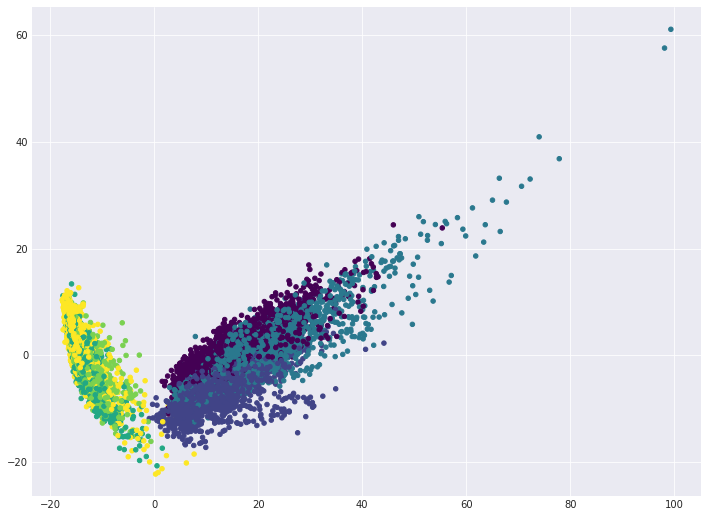

In [ ]:
plt.scatter(a, b, c = y, s=20, cmap='viridis');

Perform clustering with the KMeans method, training the model on data with reduced dimensionality (by PCA). In this case, we will give a clue to look for exactly 6 clusters, but in general case we will not know how many clusters we should be looking for.

Options:

n_clusters = n_classes (number of unique labels of the target class)

n_init = 100

random_state = RANDOM_STATE (for reproducibility of the result)

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=n_classes, random_state=17, n_init = 100)
kmeans.fit(X_reduced)
cluster_labels = kmeans.labels_

In [ ]:
np.unique(cluster_labels)

array([0, 1, 2, 3, 4, 5], dtype=int32)

Visualize data in projection on the first two principal components. Color the dots according to the clusters obtained.

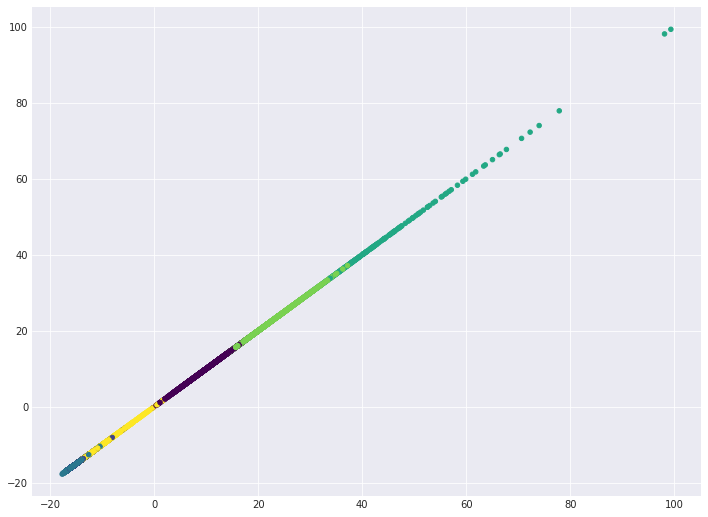

In [ ]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 0], c=cluster_labels, s=20, cmap='viridis');

Look at the correspondence between the cluster marks and the original class labels and what kinds of activities the KMeans algorithm is confused at.

In [ ]:
cluster_labels, y

(array([1, 1, 1, ..., 0, 0, 0], dtype=int32), array([5, 5, 5, ..., 2, 2, 2]))

In [ ]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab

col_0,0,1,2,3,4,5,All
row_0,,,,,,,
1,903,0,0,78,741,0,1722
2,1241,0,0,5,296,2,1544
3,320,0,0,196,890,0,1406
4,1,1235,91,0,0,450,1777
5,0,1344,0,0,0,562,1906
6,5,52,1558,0,0,329,1944
All,2470,2631,1649,279,1927,1343,10299


In [ ]:
tab.index = ['walking', 'going up the stairs',
            'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab

col_0,0,1,2,3,4,5,All
walking,903,0,0,78,741,0,1722
going up the stairs,1241,0,0,5,296,2,1544
going down the stairs,320,0,0,196,890,0,1406
sitting,1,1235,91,0,0,450,1777
standing,0,1344,0,0,0,562,1906
laying,5,52,1558,0,0,329,1944
all,2470,2631,1649,279,1927,1343,10299


In [ ]:
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['all']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
walking,903,0,0,78,741,0,1722
going up the stairs,1241,0,0,5,296,2,1544
going down the stairs,320,0,0,196,890,0,1406
sitting,1,1235,91,0,0,450,1777
standing,0,1344,0,0,0,562,1906
laying,5,52,1558,0,0,329,1944
all,2470,2631,1649,279,1927,1343,10299


We see that for each class (i.e., each activity) there are several clusters. Let’s look at the maximum percentage of objects in a class that are assigned to a single cluster. This will be a simple metric that characterizes how easily the class is separated from others when clustering.

Example: if for class “walking downstairs” (with 1406 instances belonging to it), the distribution of clusters is:

cluster 1 - 900

cluster 3 - 500

cluster 6 - 6,

then such a share will be 900/1406  = 0.64.

In [ ]:
tab.iloc[[0],[0]]

,cluster1
walking,903


In [ ]:
claster_dict = {}

In [ ]:
tab.index

Index(['walking', 'going up the stairs', 'going down the stairs', 'sitting',
       'standing', 'laying', 'all'],
      dtype='object')

In [ ]:
%%time
claster_dict = {}
for i in tab.index:
  list_clast = []
  for j in tab.columns:
    list_clast.append(round((tab[j][i] / tab['all'][i]),2))
  claster_dict[i] = list_clast

CPU times: user 2.65 ms, sys: 0 ns, total: 2.65 ms
Wall time: 2.97 ms


## Question 4:
Which activity is separated from the rest better than others based on the simple metric described above?

In [ ]:
for key in claster_dict.keys():
  print(f"{key}: {claster_dict[key][:5]}")

walking: [0.52, 0.0, 0.0, 0.05, 0.43]
going up the stairs: [0.8, 0.0, 0.0, 0.0, 0.19]
going down the stairs: [0.23, 0.0, 0.0, 0.14, 0.63]
sitting: [0.0, 0.69, 0.05, 0.0, 0.0]
standing: [0.0, 0.71, 0.0, 0.0, 0.0]
laying: [0.0, 0.03, 0.8, 0.0, 0.0]
all: [0.24, 0.26, 0.16, 0.03, 0.19]


It can be seen that kMeans does not distinguish activities very well. Use the elbow method to select the optimal number of clusters. Parameters of the algorithm and the data we use are the same as before, we change only n_clusters.

In [ ]:
for k in tqdm_notebook(range(1, n_classes + 1)):
  print(k)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/6 [00:00<?, ?it/s]

1
2
3
4
5
6


In [ ]:
kmeans.inertia_ # это и есть параметр 
#nertia measures how well a dataset was clustered by K-Means. 
#It is calculated by measuring the distance between each data point and its 
#centroid, squaring this distance, and summing these squares across one cluster.

2003454.8999158177

In [ ]:
%%time
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=17) \
    .fit(X_reduced)
    inertia.append(np.sqrt(kmeans.inertia_))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/6 [00:00<?, ?it/s]

CPU times: user 1min 13s, sys: 30 s, total: 1min 43s
Wall time: 53 s


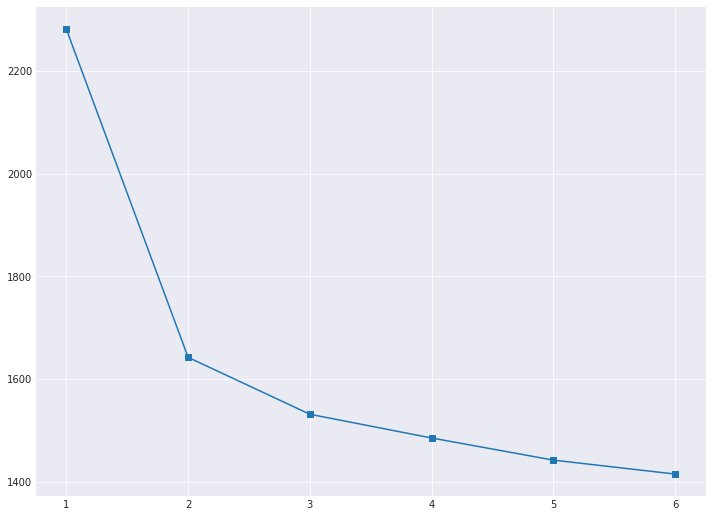

In [ ]:
plt.plot(range(1, 7), inertia, marker="s");

In [ ]:
d = {}
for k in range(2, 6):
    i = k - 1
    d[k] = (inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])

In [ ]:
d

{2: 0.17344753560094336,
 3: 0.41688555755862233,
 4: 0.9332195900967719,
 5: 0.6297019542007607}

Let’s try another clustering algorithm, described in the article – agglomerative clustering.

In [ ]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_reduced)

In [ ]:
ag.labels_

array([1, 1, 1, ..., 2, 2, 2])

Calculate the Adjusted Rand Index (sklearn.metrics) for the resulting clustering and for KMeans with the parameters from the 4th question.

In [ ]:
from sklearn.metrics import adjusted_rand_score

In [ ]:
adjusted_rand_score(y, ag.labels_), adjusted_rand_score(y, kmeans.labels_)

(0.49362763373004886, 0.4198070012602345)

For classification, use the support vector machine 
Choose the C hyperparameter for LinearSVC using GridSearchCV.

Train the new StandardScaler on the training set (with all original features), apply scaling to the test set

In GridSearchCV, specify cv = 3.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

In [ ]:
svc = LinearSVC(random_state=17)
svc_params = {"C": [0.001, 0.01, 0.1, 1, 10]}

In [ ]:
SVC_grid = GridSearchCV(svc, svc_params)

In [ ]:
%%time
SVC_grid.fit(X_train_scaled, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

CPU times: user 2min, sys: 2.79 s, total: 2min 3s
Wall time: 2min 7s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


GridSearchCV(estimator=LinearSVC(random_state=17),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [ ]:
SVC_grid.best_score_, SVC_grid.best_params_

(0.9412495548865365, {'C': 0.1})

In [ ]:
y_pred = SVC_grid.predict(X_test_scaled)

In [ ]:
tab = pd.crosstab(y_test, y_pred, margins=True)
tab.index = ['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab.columns = ['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab

,walking,climbing up the stairs,going down the stairs,sitting,standing,laying,all
walking,494,2,0,0,0,0,496
climbing up the stairs,12,459,0,0,0,0,471
going down the stairs,2,3,414,1,0,0,420
sitting,0,4,0,426,61,0,491
standing,0,0,0,15,517,0,532
laying,0,0,0,0,11,526,537
all,508,468,414,442,589,526,2947


## Question 8:
Which activity type is worst detected by SVM in terms of precision? Recall?

In [ ]:
%%time
claster_dict = {}
for i in tab.index:
  list_clast = []
  for j in tab.columns:
    list_clast.append(round((tab[j][i] / tab['all'][i]),2))
  claster_dict[i] = list_clast

CPU times: user 3.99 ms, sys: 999 µs, total: 4.99 ms
Wall time: 5.35 ms


In [ ]:
for key in claster_dict.keys():
  print(f"{key}: {claster_dict[key][:5]}")

walking: [1.0, 0.0, 0.0, 0.0, 0.0]
climbing up the stairs: [0.03, 0.97, 0.0, 0.0, 0.0]
going down the stairs: [0.0, 0.01, 0.99, 0.0, 0.0]
sitting: [0.0, 0.01, 0.0, 0.87, 0.12]
standing: [0.0, 0.0, 0.0, 0.03, 0.97]
laying: [0.0, 0.0, 0.0, 0.0, 0.02]
all: [0.17, 0.16, 0.14, 0.15, 0.2]


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
precision_recall_fscore_support(y_test, y_pred)

(array([0.97244094, 0.98076923, 1.        , 0.9638009 , 0.87775891,
        1.        ]),
 array([0.99596774, 0.97452229, 0.98571429, 0.86761711, 0.97180451,
        0.97951583]),
 array([0.98406375, 0.97763578, 0.99280576, 0.91318328, 0.92239072,
        0.98965193]),
 array([496, 471, 420, 491, 532, 537]))

In [ ]:
y_test, y_pred

(array([5, 5, 5, ..., 2, 2, 2]), array([5, 5, 5, ..., 2, 2, 2]))

In [ ]:
#precision – standing, recall – sitting

Finally, do the same thing as in Question 7, but add PCA.

Use X_train_scaled and X_test_scaled

Train the same PCA as before, on the scaled training set, apply scaling to the test set

Choose the hyperparameter C via cross-validation on the training set with PCA-transformation. You will notice how much faster it works now.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.9, random_state=17)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {"C": [0.001, 0.01, 0.1, 1, 10]}

In [ ]:
%%time
best_svc_pca = GridSearchCV(svc, svc_params, n_jobs=4, cv=3, verbose=1)
best_svc_pca.fit(X_train_pca, y_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits
CPU times: user 1.84 s, sys: 147 ms, total: 1.99 s
Wall time: 17.2 s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


GridSearchCV(cv=3, estimator=LinearSVC(random_state=17), n_jobs=4,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]}, verbose=1)

In [ ]:
best_svc_pca.best_params_, best_svc_pca.best_score_

({'C': 1}, 0.8998943094169531)

In [ ]:
round(100 * (best_svc_pca.best_score_ - SVC_grid.best_score_))

-4

# Question 9:
What is the difference between the best quality (accuracy) for cross-validation in the case of all 561 initial characteristics and in the second case, when the principal component method was applied? Round to the nearest percent.